In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [9]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [6]:
def plot_muts_per_read(selected_fmod_run_id, selected_valtype, selected_sample=None):
    """
    Locate the per-read histogram outputs for a probe_fmod_run and plot them if available.

    Parameters
    ----------
    selected_fmod_run_id : int
        probe_fmod_runs.id to inspect.
    selected_valtype : str
        Either "modrate" (standard per-read histogram) or "modrateGA" (GA-only histogram).
    selected_sample : str | None
        Optional sequencing_samples.sample_name to further constrain the lookup.
    """
    if selected_fmod_run_id is None:
        print("Set `selected_fmod_run_id` before calling this helper.")
        return None

    params = {"run_id": selected_fmod_run_id}
    query = """
        SELECT r.id AS fmod_run_id, r.output_dir, s.sample_name
        FROM probe_fmod_runs r
        JOIN sequencing_samples s ON s.id = r.s_id
        WHERE r.id = :run_id
    """
    if selected_sample:
        query += " AND s.sample_name = :sample_name"
        params["sample_name"] = selected_sample

    run_df = read_sql(query, params)
    if run_df.empty:
        print("No probe_fmod_runs row matched that id/sample combination.")
        return None

    hist_meta = {
        "modrate": ("per_read_histogram.txt", "Mutations per read"),
        "modrateGA": ("per_read_histogram.txtga", "GA mismatches per read"),
    }
    if selected_valtype not in hist_meta:
        print("`selected_valtype` must be either 'modrate' or 'modrateGA' for per-read histograms.")
        return None
    hist_filename, x_label = hist_meta[selected_valtype]

    run_row = run_df.iloc[0]
    sample_name = run_row["sample_name"]
    raw_output_dir = run_row["output_dir"]
    print(f"Run {selected_fmod_run_id} (sample: {sample_name})")
    print(f"Stored output_dir: {raw_output_dir}")

    output_path = Path(raw_output_dir).expanduser()
    pipeline_root = (db_path.parent if "db_path" in globals() else Path.cwd())
    repo_root = pipeline_root.parent

    def _candidate_dirs():
        seen = set()

        def _emit(path: Path):
            key = str(path)
            if key not in seen:
                seen.add(key)
                yield path

        for item in _emit(output_path):
            yield item

        parts = output_path.parts
        if "mut_count" in parts:
            last_idx = max(i for i, part in enumerate(parts) if part == "mut_count")
            suffix = Path(*parts[last_idx:])
            for base in (
                pipeline_root,
                pipeline_root / "04_run_mutcounts",
                repo_root,
                repo_root / "examples",
            ):
                if base:
                    candidate = base / suffix
                    for item in _emit(candidate):
                        yield item

    checked = []
    found = {}
    for dir_candidate in _candidate_dirs():
        for filename in ("per_read_histogram.txt", "per_read_histogram.txtga"):
            hist_path = dir_candidate / filename
            checked.append(hist_path)
            if hist_path.exists():
                found[filename] = hist_path

    if found:
        for name, path in found.items():
            print(f"✓ Found {name} at {path}")
    else:
        print("No histogram files found. Checked the following paths:")
        for path in checked:
            print(f" - {path}")

    hist_path = found.get(hist_filename)
    hist_df = None
    fig = ax = None
    if hist_path is None:
        print(f"Could not locate {hist_filename} for this run.")
    else:
        try:
            hist_df = pd.read_csv(hist_path, sep="\t")
            hist_df = hist_df.sort_values("bin_left")
        except Exception as exc:
            print(f"Failed to read {hist_path}: {exc}")
        else:
            fig, ax = plt.subplots(figsize=(6, 3))
            ax.bar(hist_df["bin_left"], hist_df["frequency"], width=0.9, alpha=0.7, color="tab:blue")
            ax.set_xlabel(x_label)
            ax.set_ylabel("Frequency")
            ax.set_title(f"Per-read histogram – run {selected_fmod_run_id}")
            ax.set_xticks(hist_df["bin_left"].astype(int))
            ax.set_ylim(0, hist_df["frequency"].max() * 1.05)
            ax.margins(x=0)
            plt.tight_layout()

    return {
        "run": run_row,
        "hist_files": found,
        "checked": checked,
        "histogram": hist_df,
        "figure": fig,
        "axes": ax,
    }


Run 109 (sample: 003-HIV-WT-25c-a-3-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_HDX_Chemprobing_2025/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_HDX_Chemprobing_2025/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p/per_read_histogram.txtga


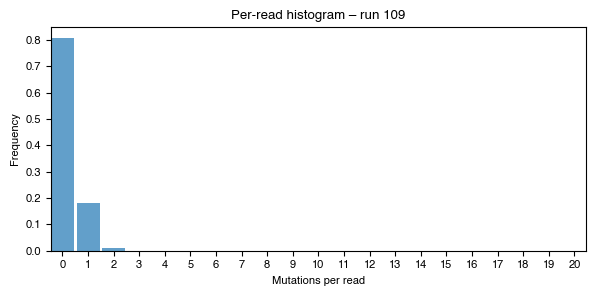

In [7]:
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

plot_muts_per_read(109, "modrate")
conn.close()

Run 51 (sample: 049-HIV-A35G-25c-a-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-cf60979/artifacts/049-HIV-A35G-25c-a-1-p
✓ Found per_read_histogram.txt at /Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.065.refactoring_data_analysis/manuscript_pipeline/04_run_mutcounts/mut_count/mut_count___cfg-cf60979/artifacts/049-HIV-A35G-25c-a-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.065.refactoring_data_analysis/manuscript_pipeline/04_run_mutcounts/mut_count/mut_count___cfg-cf60979/artifacts/049-HIV-A35G-25c-a-1-p/per_read_histogram.txtga
Run 52 (sample: 050-HIV-A35G-25c-a-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_st

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_41803/2181770962.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 3))


Run 109 (sample: 003-HIV-WT-25c-a-3-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p
✓ Found per_read_histogram.txt at /Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.065.refactoring_data_analysis/manuscript_pipeline/04_run_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.065.refactoring_data_analysis/manuscript_pipeline/04_run_mutcounts/mut_count/mut_count___cfg-cf7fea6/artifacts/003-HIV-WT-25c-a-3-p/per_read_histogram.txtga
Run 110 (sample: 004-HIV-WT-25c-a-4-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardiz

,probe_fmod_run_id,sample_name,reaction_time,treated,construct.disp_name,0mut,1mut,2mut
0,51,049-HIV-A35G-25c-a-1-p,900.0,1,hiv_a35g,0.875461,0.118920,0.005501
1,52,050-HIV-A35G-25c-a-2-p,3000.0,1,hiv_a35g,0.849436,0.143960,0.006537
2,53,051-HIV-A35G-25c-a-3-p,5400.0,1,hiv_a35g,0.815812,0.174286,0.009706
3,54,052-HIV-A35G-25c-a-4-p,9600.0,1,hiv_a35g,0.800302,0.188121,0.011363
4,55,053-HIV-A35G-25c-a-5-p,19200.0,1,hiv_a35g,0.802684,0.186140,0.010955
5,56,054-HIV-A35G-25c-a-6-p,27000.0,1,hiv_a35g,0.790226,0.196865,0.012728
6,86,001-HIV-C30U-25c-a-1-p,900.0,1,hiv_c30u,0.901878,0.094231,0.003702
7,87,002-HIV-C30U-25c-a-2-p,3000.0,1,hiv_c30u,0.854360,0.138337,0.007178
8,88,003-HIV-C30U-25c-a-3-p,5400.0,1,hiv_c30u,0.825867,0.164314,0.009573
9,89,004-HIV-C30U-25c-a-4-p,9600.0,1,hiv_c30u,0.790690,0.194869,0.014071


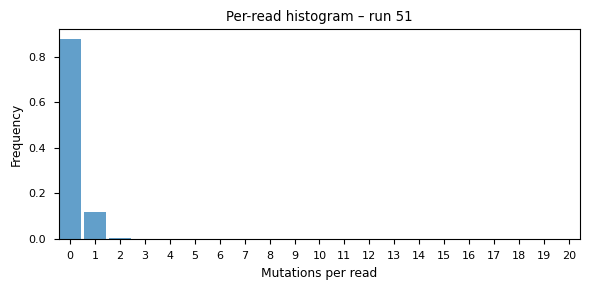

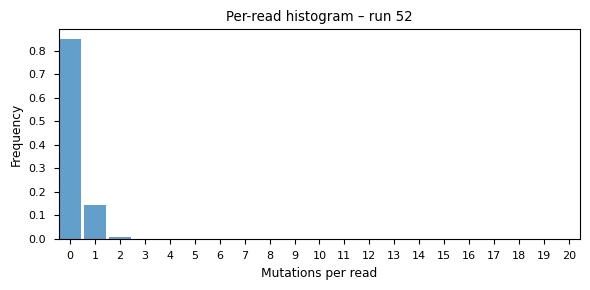

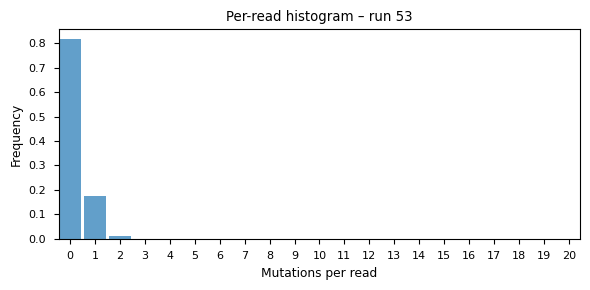

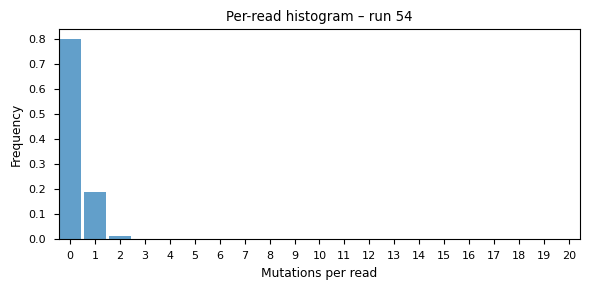

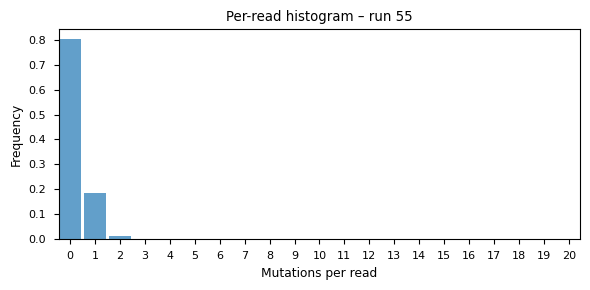

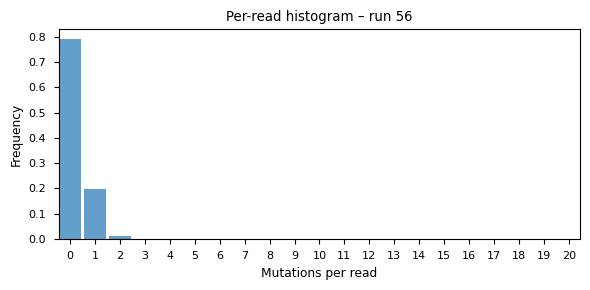

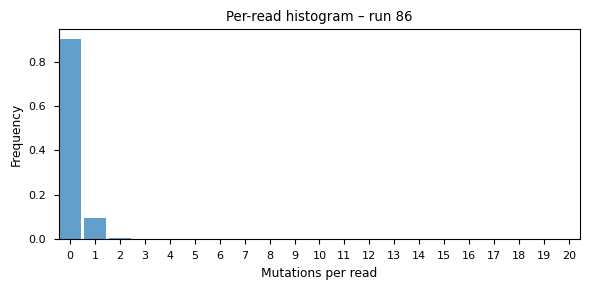

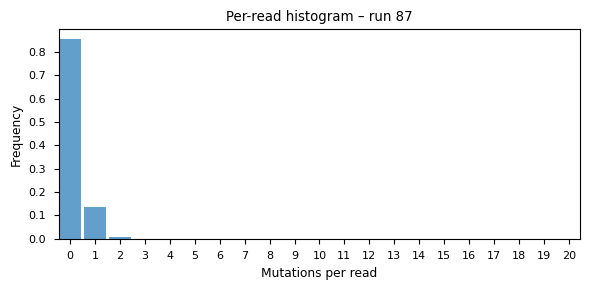

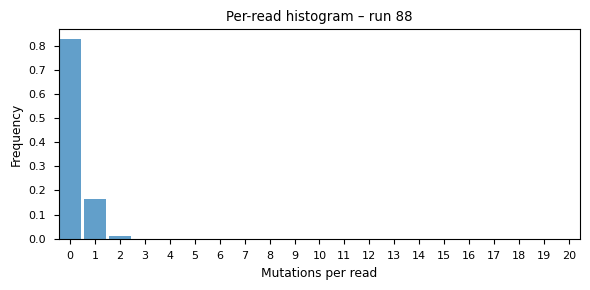

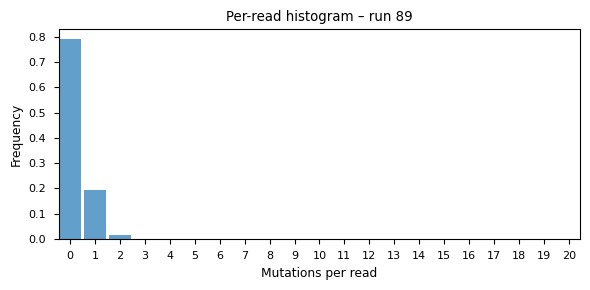

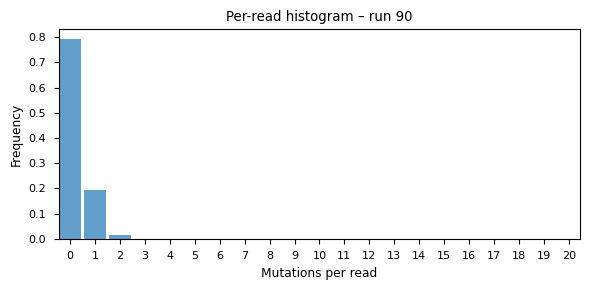

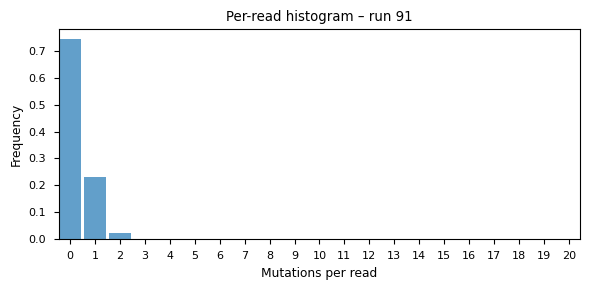

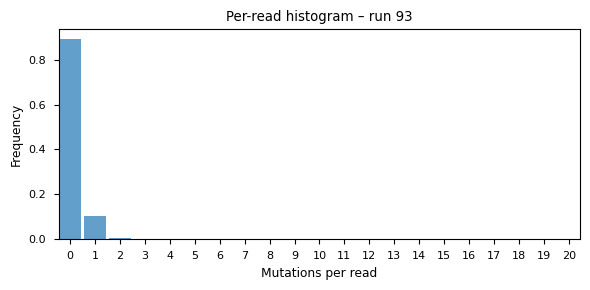

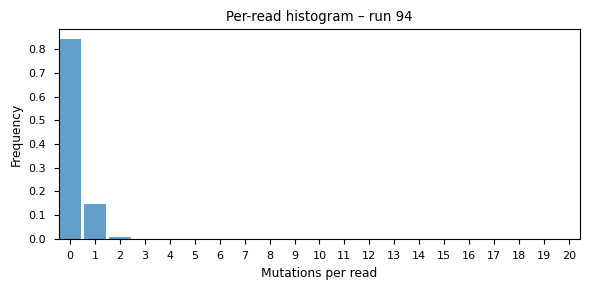

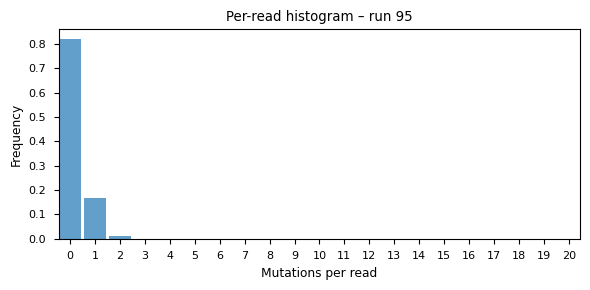

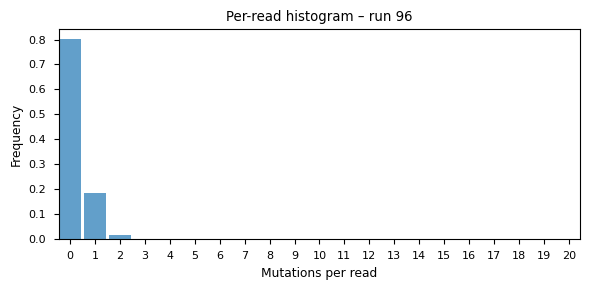

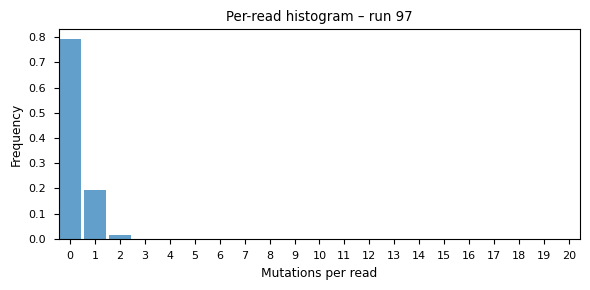

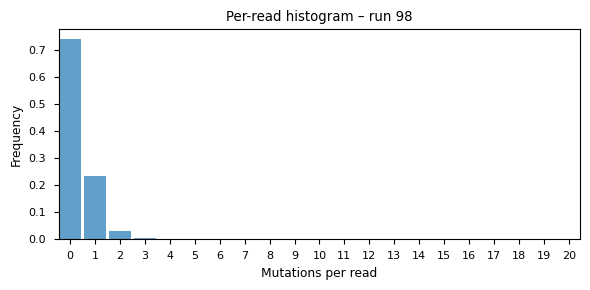

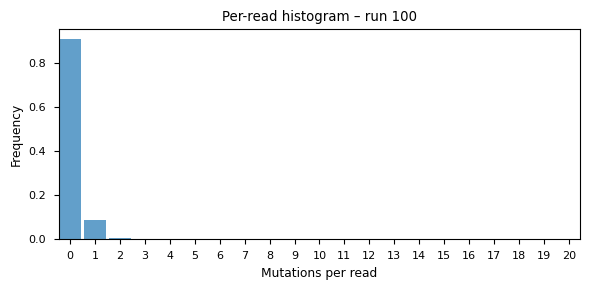

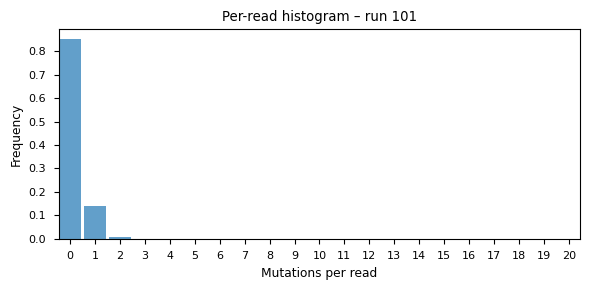

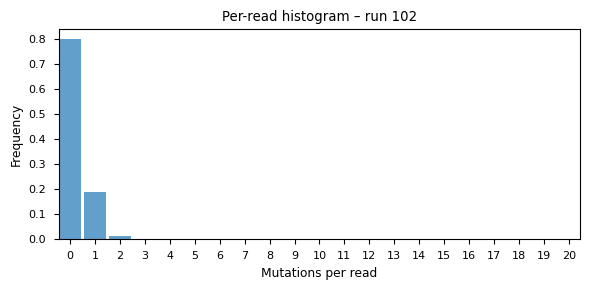

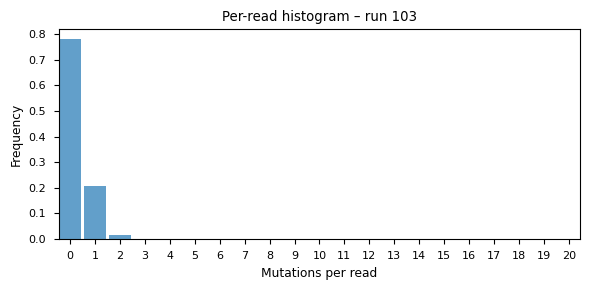

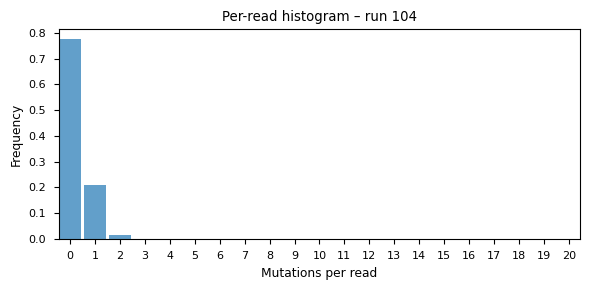

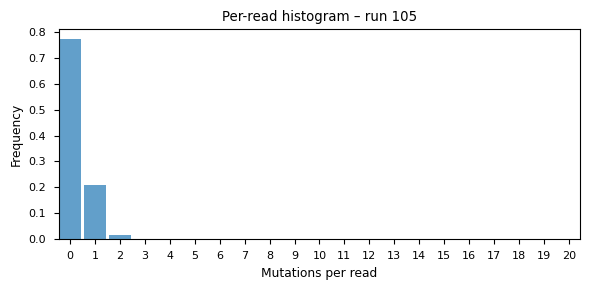

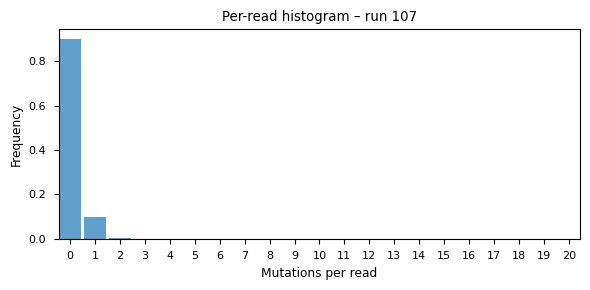

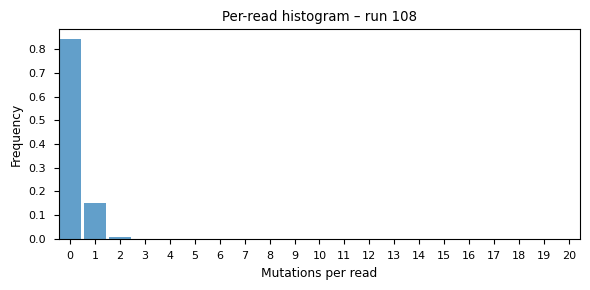

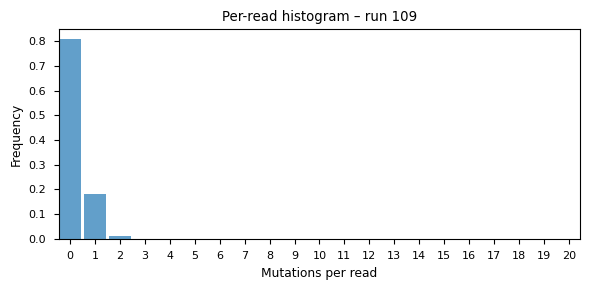

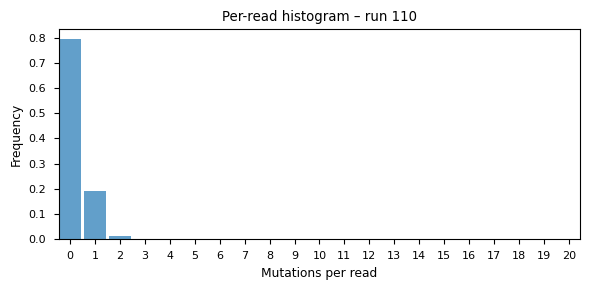

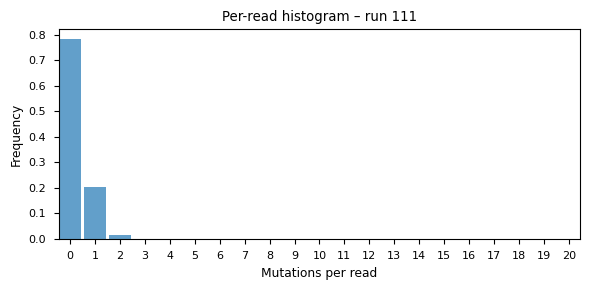

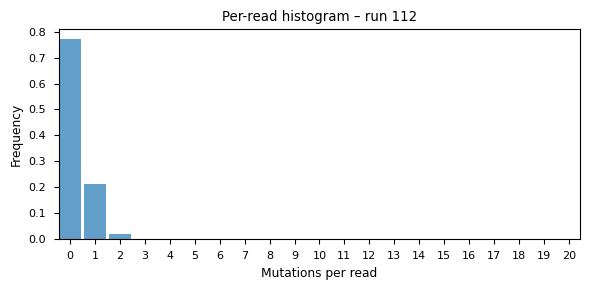

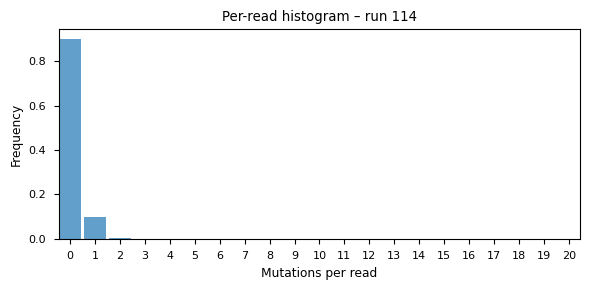

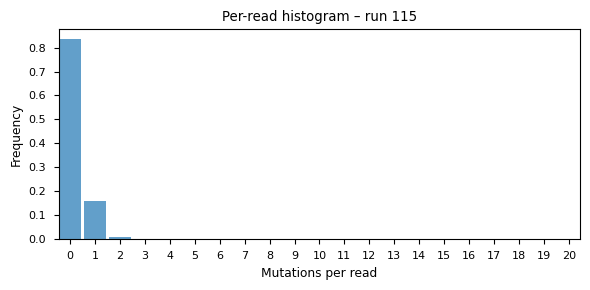

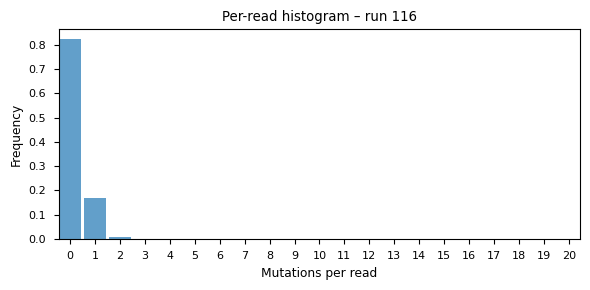

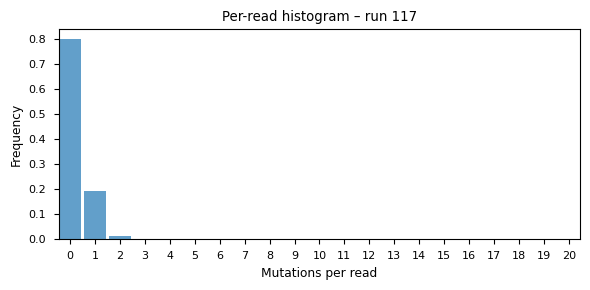

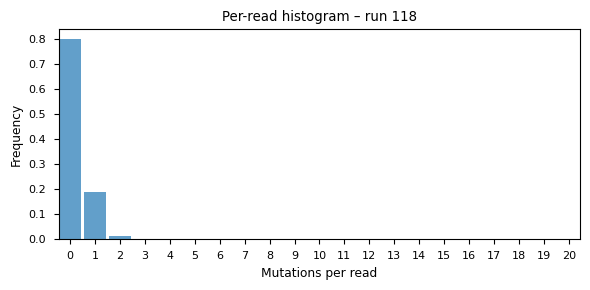

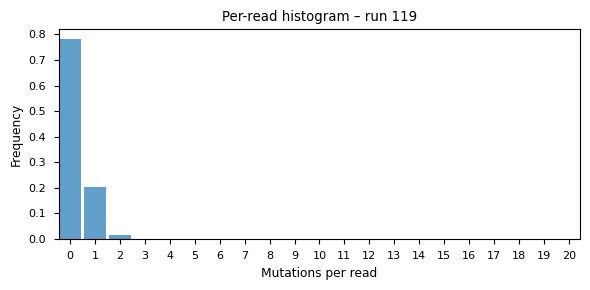

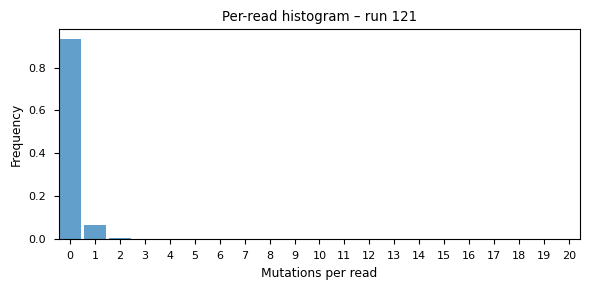

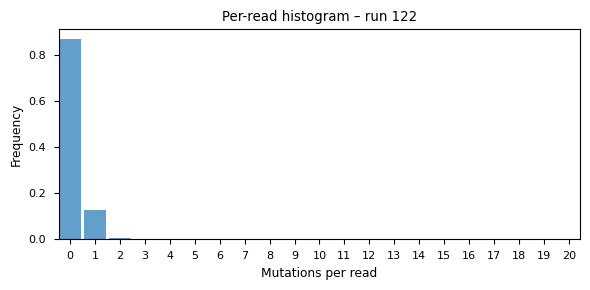

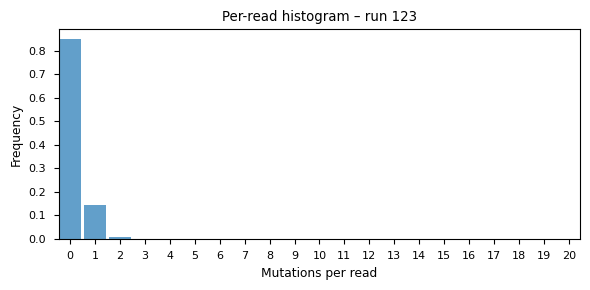

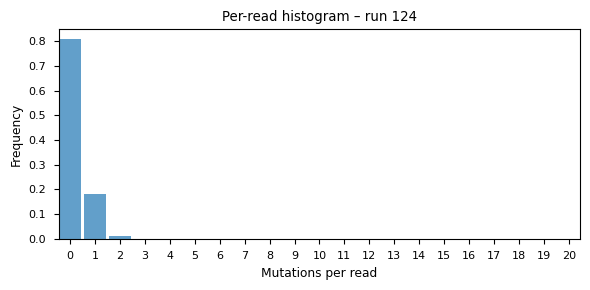

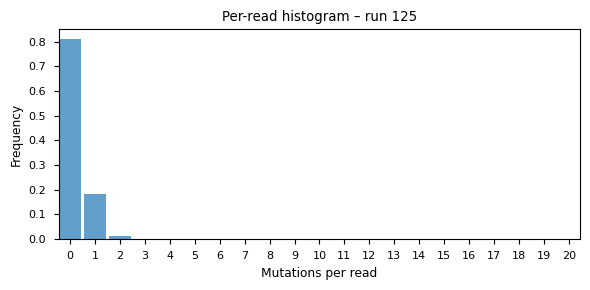

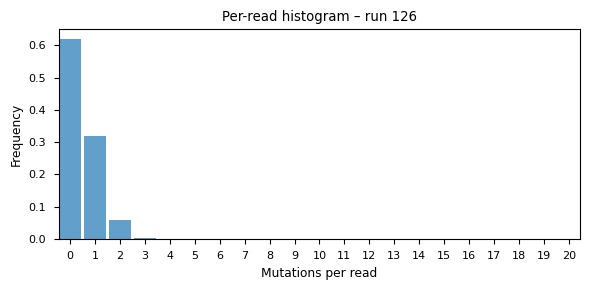

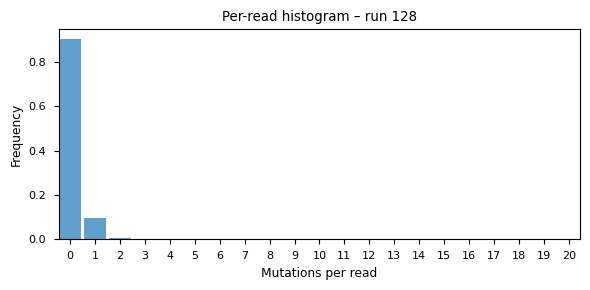

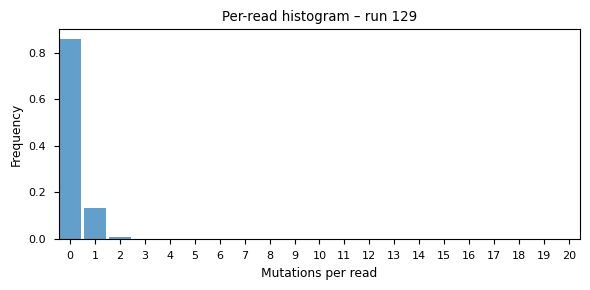

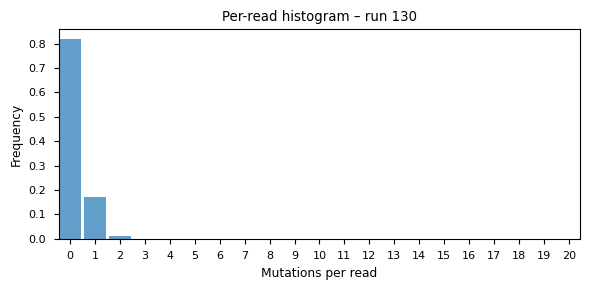

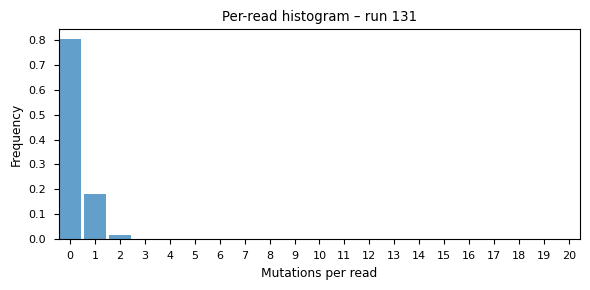

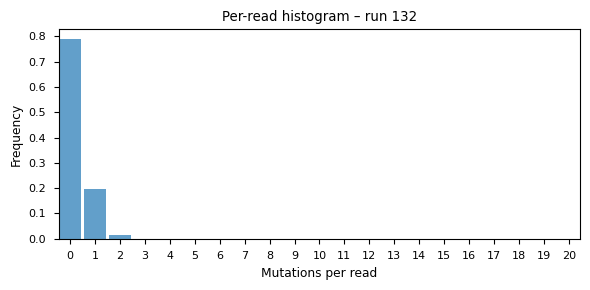

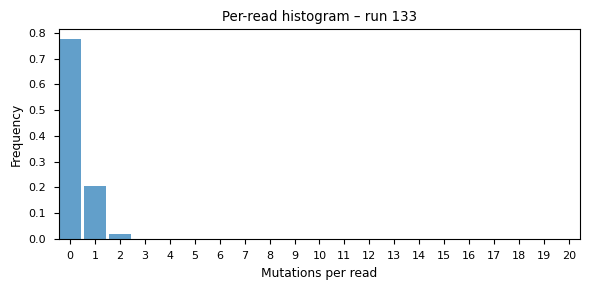

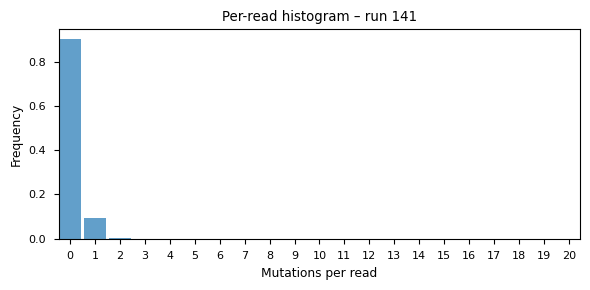

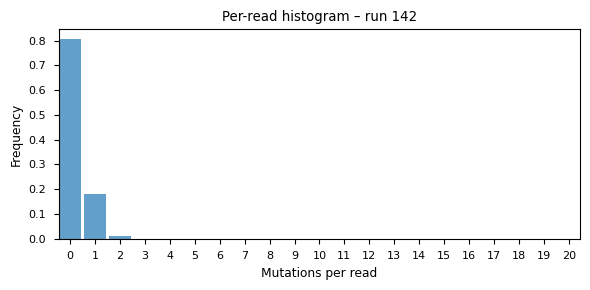

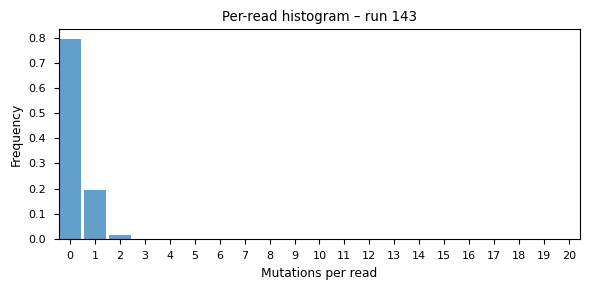

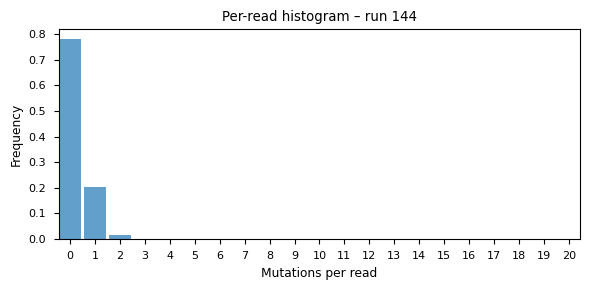

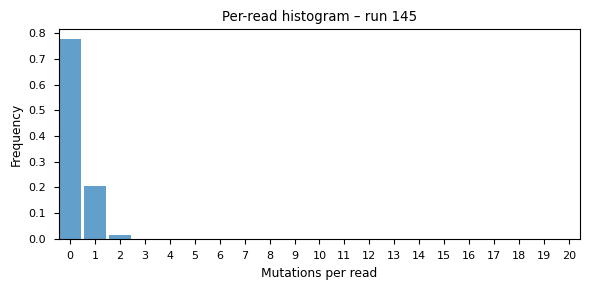

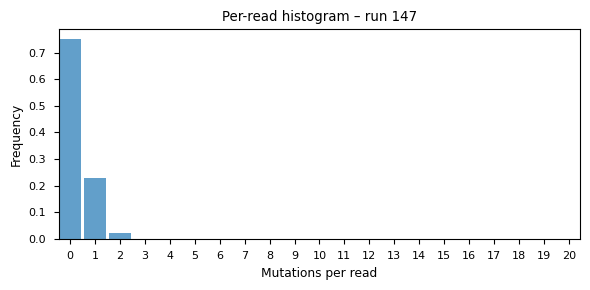

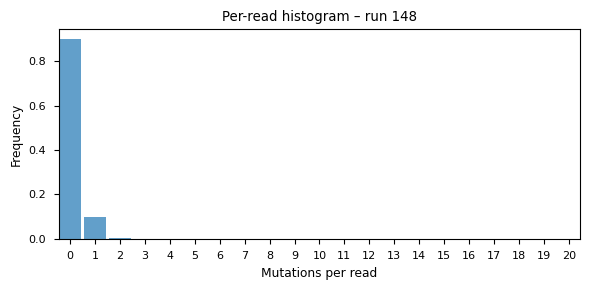

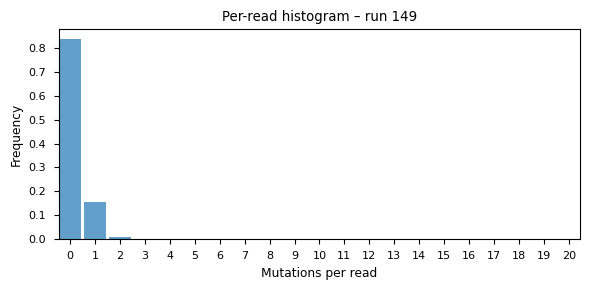

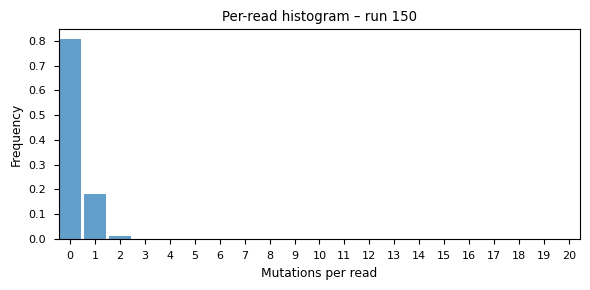

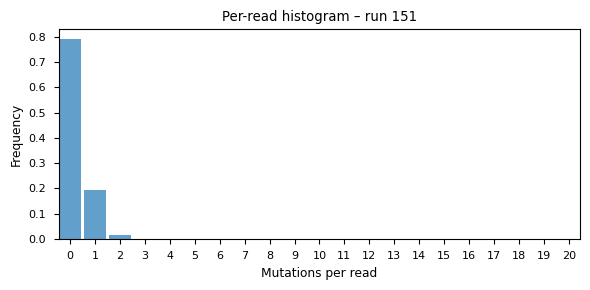

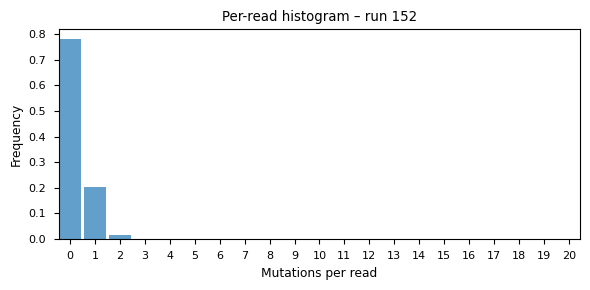

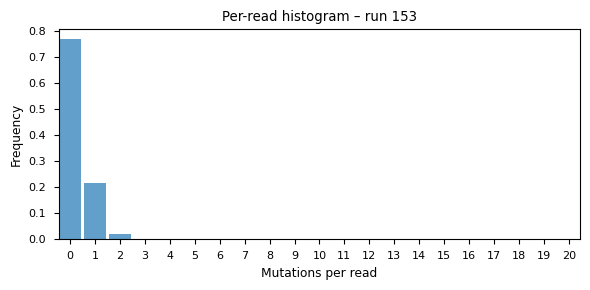

In [16]:
def find_probe_fmod_runs(
    selected_fmod_run_id: int | None = None,
    sample_name: str | None = None,
    treated_flag: int | None = None,
    construct_family: str | None = None,
) -> pd.DataFrame:
    """
    Retrieve probe_fmod_run rows with sequencing sample, reaction, and construct context.

    Returns a DataFrame with:
        probe_fmod_run_id, sample_name, reaction_time, treated, construct.disp_name
    """
    conditions = ["pr.temperature = 25"]
    params: dict[str, object] = {}

    if selected_fmod_run_id is not None:
        conditions.append("r.id = :fmod_run_id")
        params["fmod_run_id"] = selected_fmod_run_id
    if sample_name:
        conditions.append("s.sample_name = :sample_name")
        params["sample_name"] = sample_name
    if treated_flag is not None:
        conditions.append("pr.treated = :treated")
        params["treated"] = treated_flag
    if construct_family:
        conditions.append("mc.family = :construct_family")
        params["construct_family"] = construct_family

    where_clause = " AND ".join(conditions)

    query = f"""
        SELECT
            r.id AS probe_fmod_run_id,
            s.sample_name,
            pr.reaction_time,
            pr.treated,
            mc.disp_name AS "construct.disp_name"
        FROM probe_fmod_runs r
        JOIN sequencing_samples s ON s.id = r.s_id
        JOIN probe_reactions pr ON pr.s_id = s.id
        JOIN meta_constructs mc ON mc.id = pr.construct_id
        WHERE {where_clause}
        ORDER BY r.id, pr.reaction_time
    """
    return read_sql(query, params)

def attach_per_read_bin_frequencies(result_df: pd.DataFrame, selected_valtype: str = "modrate") -> pd.DataFrame:
    """
    For each probe_fmod_run in result_df, look up the per-read histogram and add 0/1/2 mutation frequencies.

    Parameters
    ----------
    result_df : pd.DataFrame
        Output from find_probe_fmod_runs (must contain probe_fmod_run_id and sample_name).
    selected_valtype : str
        Pass "modrate" for per_read_histogram.txt or "modrateGA" for per_read_histogram.txtga.

    Returns
    -------
    pd.DataFrame
        Copy of result_df with columns '0mut', '1mut', '2mut'.
    """
    bins = [0, 1, 2]
    annotated = result_df.copy()
    for b in bins:
        annotated[f"{b}mut"] = np.nan

    for idx, row in annotated.iterrows():
        run_id = row["probe_fmod_run_id"]
        sample = row.get("sample_name")
        lookup = plot_muts_per_read(run_id, selected_valtype, selected_sample=sample)
        hist_df = (lookup or {}).get("histogram")
        if hist_df is None:
            continue

        freq_map = dict(zip(hist_df["bin_left"].astype(int), hist_df["frequency"]))
        for b in bins:
            annotated.at[idx, f"{b}mut"] = freq_map.get(b, 0.0)

    return annotated


nerd_sqlite = 'nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

result_df = find_probe_fmod_runs(construct_family='HIV-1_TAR', treated_flag = 1)
result_df = attach_per_read_bin_frequencies(result_df, selected_valtype="modrate")

conn.close()
result_df

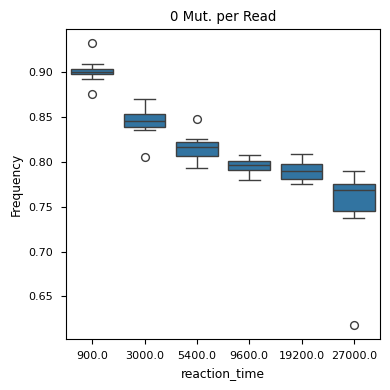

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.boxplot(data=result_df, x='reaction_time', y='0mut', ax=ax)

ax.set_title('0 Mut. per Read')
ax.set_ylabel('Frequency')

plt.tight_layout()
#plt.savefig('mutation_frequencies_boxplots.pdf')
plt.show()

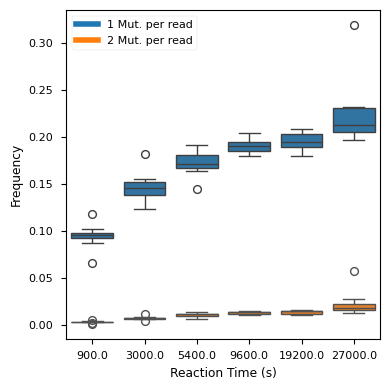

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#sns.boxplot(data=result_df, x='reaction_time', y='0mut', ax=ax)
sns.boxplot(data=result_df, x='reaction_time', y='1mut', ax=ax)
sns.boxplot(data=result_df, x='reaction_time', y='2mut', ax=ax)

# y-axis labels
ax.set_ylabel('Frequency')

# set xlabel
ax.set_xlabel('Reaction Time (s)')

# legend
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4)]
ax.legend(custom_lines, ['1 Mut. per read', '2 Mut. per read'], loc='upper left')


plt.tight_layout()
plt.savefig('mutation_frequencies_boxplots_integrated.pdf')
plt.show()